# Tehtävä 1.
## Aihe: Uutisotsikon klassifiointi - Clickbait vai ei?
2,5 pistettä

Datasetin kuvaus GitHubissa:
https://github.com/bhargaviparanjape/clickbait/tree/master/dataset

1. Lataa clickbait ja ei-clickbait otsikot clickbait_data.txt ja non_clickbait_data.txt tiedostoista data - kansiosta
2. Leimaa otsikot 0 tai 1 luokkaan (clickbait vai ei)
2. Jaa data koulutus- ja testidataan (80% koulutusdataa 20% testidataa jako)
4. Luo RNN - malli, joka ennustaa, onko otsikko clickbait vai ei
5. Tulosta mallin tarkkuus evaluate - funktiolla
6. Aja "Tehtävän vastaukset" solu

Vinkkejä:
* Käytä materiaaleista tuttua Tokenizer - luokkaa
* Luo otsikoista samanpituiset sekvenssit

In [10]:
import pandas as pd 
from sklearn.model_selection import train_test_split
import tensorflow as tf

# Tehtävän toteutus

# Lataa clickbait ja ei-clickbait otsikot clickbait_data.txt ja non_clickbait_data.txt tiedostoista data - kansiosta
# Leimaa otsikot 0 tai 1 luokkaan (clickbait vai ei)
df1 = pd.read_csv('data/clickbait_data.txt', sep=',', names=['Header'])
df1.dropna(inplace=True)
df1['Class'] = 1
df2 = pd.read_csv('data/non_clickbait_data.txt', sep=',', names=['Header'])
df2.dropna(inplace=True)
df2['Class'] = 0
df = pd.concat([df1, df2], axis=0).reset_index(drop=True)
df['Class'] = df['Class'].astype(int)

print(df)

# Jaa data koulutus- ja testidataan (80% koulutusdataa 20% testidataa jako)
X = df['Header']
y = df ['Class']
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.20, shuffle=True, stratify=y)

# Luo RNN - malli, joka ennustaa, onko otsikko clickbait vai ei
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=65000)
tokenizer.fit_on_texts(X)

# tekstit sekvensseiksi
train_X = tokenizer.texts_to_sequences(train_X)
test_X = tokenizer.texts_to_sequences(test_X)

# tekstit samankokoisiksi
train_X = tf.keras.preprocessing.sequence.pad_sequences(train_X, maxlen=df['Header'].map(len).max(), padding='post')
test_X = tf.keras.preprocessing.sequence.pad_sequences(test_X, maxlen=df['Header'].map(len).max(), padding='post')

input_layer = tf.keras.Input(shape=(135,))
emb = tf.keras.layers.Embedding(65000,2,input_length=train_X.shape[1])(input_layer)
lstm = tf.keras.layers.LSTM(64, return_sequences=True,dropout=0.1)(emb)
do = tf.keras.layers.Dropout(0.5)(lstm)
flat = tf.keras.layers.Flatten()(do)
dense = tf.keras.layers.Dense(64, activation='relu')(flat)
out = tf.keras.layers.Dense(1, activation='sigmoid')(dense)
model = tf.keras.Model(inputs=input_layer, outputs=out)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(train_X, train_y, validation_data=(test_X, test_y), epochs=5)
results = model.evaluate(test_X, test_y)

                                                  Header  Class
0                                     Should I Get Bings      1
1          Which TV Female Friend Group Do You Belong In      1
2      The New "Star Wars: The Force Awakens" Trailer...      1
3      This Vine Of New York On "Celebrity Big Brothe...      1
4      A Couple Did A Stunning Photo Shoot With Their...      1
...                                                  ...    ...
31840              To Make Female Hearts Flutter in Iraq      0
31841              British Liberal Democrat Patsy Calton      0
31842  Drone smartphone app to help heart attack vict...      0
31843                      Netanyahu Urges Pope Benedict      0
31844  Computer Makers Prepare to Stake Bigger Claim ...      0

[31845 rows x 2 columns]
(25476, 135)
(6369, 135)
Epoch 1/5
797/797 [==============================] - 77s 96ms/step - loss: 0.1961 - accuracy: 0.9165 - val_loss: 0.0811 - val_accuracy: 0.9716
Epoch 2/5
797/797 [===================

In [11]:
# Tehtävän vastaukset. Huom! Älä muokkaa tätä solua, vaan aja se, kun olet suorittanut tehtävän. Sijoita results - muuttujaan funktion model.evaluate() tulos.
# Muista määrittää model.compile() - funktioon seurattavaksi suureeksi metrics=['accuracy'], jotta näät, kuinka suuri osa neuroverkon ennustuksista on oikein.
print(f"Test Loss:{results[0]} Test Accuracy:{results[1]*100}%")

Test Loss:0.10173167288303375 Test Accuracy:97.07960486412048%


# Tehtävä 2.
### Aihe: Aikasarjaennustaminen - Lämpötila ja sähkönkulutus
2,5 pistettä

Data - kansiossa tiedostoissa 'lampotila_2010.csv' ja 'sahkonkulutus_2010.csv' on vuoden 2010 tammikuun lämpötila Jyväskylän lentoasemalta ja koko Suomen sähkönkulutus. Tavoitteena on luoda neuroverkkomalli, joka ennustaa sähkönkulutuksen ja lämpötilan avulla tulevaa sähkönkulutusta.

1. Ennusta 24 tunnin historiadatalla 24 tuntia eteenpäin
2. Kouluta neuroverkko vuoden 2010 tammikuun datalla.
3. Luo testidatasetti 'lampotila_2011.csv' ja 'sahkonkulutus_2011.csv' tiedostoista
4. Ennusta mallilla vuoden 2011 tammikuun sähkönkulutusta. Piirrä oikeat arvot ja ennustetut arvot viivakaavioon.
5. Aja "Tehtävän vastaukset" solu

Vinkkejä:
* Muuta aikasarja sekvenssimuotoon käyttäen multivariate_data - funktiota materiaaleista.
    * Mitkä ovat muuttujia, joiden avulla ennustetaan, ja mitkä ovat ennustettavia arvoja?
* Dataa on vähän, joten ennustustulokset saattavat olla huonoja
    * Tärkeintä on, että idea on oikein
    * Käytä Dropout - kerroksia ja vaihda LSTM - kerroksissa solujen määrää

In [146]:
import pandas as pd 
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

# Tehtävän toteutus

# luetaan datat dataframeihin
# Käytetään parse_dates parametriä luomaan yksi aikaleima sarake "Vuosi", "Kk", "Pv" ja "Klo" sarakkeista
df1 = pd.read_csv('data/lampotila_2010.csv',parse_dates=[['Vuosi','Kk','Pv','Klo']])
df1 = df1.rename(columns={'Vuosi_Kk_Pv_Klo':'date','Ilman lämpötila (degC)':'Temperature'})  
df2 = pd.read_csv('data/sahkonkulutus_2010.csv')
df3 = pd.read_csv('data/lampotila_2011.csv',parse_dates=[['Vuosi','Kk','Pv','Klo']])
df3 = df3.rename(columns={'Vuosi_Kk_Pv_Klo':'date','Ilman lämpötila (degC)':'Temperature'}) 
df4 = pd.read_csv('data/sahkonkulutus_2011.csv') 

# poistetaan ylimääräiset sarakkeet sähkönkulutuksesta
df2 = df2.drop(['Alkuaika UTC', 'Lopetusaika UTC', 'Lopetusaika UTC+02:00'], axis=1)
df4 = df4.drop(['Alkuaika UTC', 'Lopetusaika UTC', 'Lopetusaika UTC+02:00'], axis=1)
df2['Alkuaika UTC+02:00'] = pd.to_datetime(df2['Alkuaika UTC+02:00'])
df4['Alkuaika UTC+02:00'] = pd.to_datetime(df4['Alkuaika UTC+02:00'])

# Asetetaan aikaleima dataframejen indeksiksi
df1 = df1.set_index('date')
df3 = df3.set_index('date')
df2 = df2.set_index('Alkuaika UTC+02:00')
df4 = df4.set_index('Alkuaika UTC+02:00')
# muutetaan indeksit saman nimisiksi 
df2.index.names = ['date']
df4.index.names = ['date']

#Täytetään NaN arvot ajallisesti seuraavalla arvolla.
df1 = df1.fillna(method='bfill')
df2 = df2.fillna(method='bfill')
df3 = df3.fillna(method='bfill')
df4 = df4.fillna(method='bfill')

# yhdistetään lämpötila ja sähkönkulutus ensin samoilta vuosilta
df2 = df2.join(df1['Temperature'])
df4 = df4.join(df3['Temperature'])

# yhdistetään vuodet 2010 ja 2011
df = df2.append(df4, ignore_index=False)
print(df)

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(df.values)

def multivariate_data(dataset, target, start_index, end_index, history_size, target_size, step, single_step=False):
        data = []
        labels = []
        start_index = start_index + history_size
        
        if end_index is None:
            end_index = len(dataset) - target_size
            
        for i in range(start_index, end_index):
            indices = range(i-history_size, i, step)
            data.append(dataset[indices])
            
            if single_step:
                labels.append(target[i+target_size])
            else:
                labels.append(target[i:i+target_size])
            
        return np.array(data), np.array(labels)

past_history = 24 # edelliset 24 tuntia
future_target = 24 # seuraavat 24 tuntia
STEP = 1 # tunnin välein
TRAIN_SPLIT = len(dataset) // 2
train_X, train_y = multivariate_data(dataset, dataset[:,0], 0, TRAIN_SPLIT, past_history, future_target, STEP)
test_X, test_y = multivariate_data(dataset, dataset[:,0], TRAIN_SPLIT, None, past_history, future_target, STEP)

print(f'Single window past history: {train_X[0].shape}')
print(f'Target to predict: {train_y[0].shape}')
print("test_X:", test_X[0].shape)
print("test_y:", test_y[0].shape)
            
# Luodaan LSTM-neuroverkko ja koulutetaan se koulutusdatalla
input_layer = tf.keras.Input(shape=(train_X.shape[1], train_X.shape[2]))
input_layer.shape
lstm1 = tf.keras.layers.LSTM(100, return_sequences=True)(input_layer)
do = tf.keras.layers.Dropout(0.5)(lstm1)
lstm2 = tf.keras.layers.LSTM(50, activation='relu')(do)
out = tf.keras.layers.Dense(future_target)(lstm2)
model = tf.keras.Model(inputs=input_layer, outputs=out)
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001), loss='mse', metrics=['mse','mae'])
model.fit(train_X, train_y, validation_data=(test_X, test_y), epochs=5)

                     Sähkön kulutus Suomessa  Temperature
date                                                     
2010-01-01 00:00:00                  11214.0        -14.4
2010-01-01 01:00:00                  10809.0        -14.8
2010-01-01 02:00:00                  10467.0        -15.1
2010-01-01 03:00:00                  10251.0        -15.4
2010-01-01 04:00:00                  10173.0        -15.1
...                                      ...          ...
2011-01-31 19:00:00                  11969.0         -2.8
2011-01-31 20:00:00                  11766.0         -2.5
2011-01-31 21:00:00                  11306.0         -2.1
2011-01-31 22:00:00                  11518.0         -2.3
2011-01-31 23:00:00                  11016.0         -1.9

[1488 rows x 2 columns]
Single window past history: (24, 2)
Target to predict: (24,)
test_X: (24, 2)
test_y: (24,)
Epoch 1/5
23/23 [==============================] - 1s 62ms/step - loss: 0.3688 - mse: 0.3688 - mae: 0.5690 - val_loss: 0.1863 - va

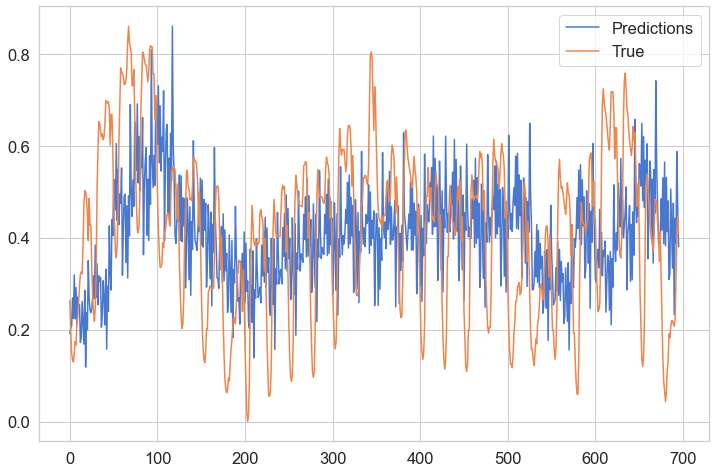

In [147]:
# Tehtävän vastaukset.  Huom! Älä muokkaa tätä solua, vaan aja se, kun olet suorittanut tehtävän. 
# Luo tarvittavat osat viivakaavioon fig - muuttujaan matplotlib - kirjastoa käyttäen. Tuloksena pitäisi olla viivakaavio, jossa on piirrettynä oikeat arvot ja neuroverkon ennustukset.
import matplotlib.pyplot as plt
predictions = model.predict(test_X, verbose=0)
nums_preds =[]
nums_real = []
index = 0
# käydään toistorakenteessa läpi ennustukset
for x in range(len(predictions) // len(predictions[0])):
    for num in predictions[index]:
        nums_preds.append(num)
    for num in test_y[index]:
        nums_real.append(num)
    # siirrytään 24 tuntia eteenpäin, kun sekvenssi oikeista arvoista ja ennustetuista arvoista on lisätty listaan
    index += len(predictions[index]) - 1
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(nums_preds, label='Predictions')
ax.plot(nums_real, label='True')
ax.legend()

# Tehtävä 3.
### Aihe: Autoenkooderit - Poikkeaman tunnistus 
2,5 pistettä

Credit card fraud - datasetissä on 28 anonymisoitua muuttujaa, jonka perusteella voi arvioida, onko luottokorttitapahtuma aito vai huijaus, joka on myös datasetissä jokaiselle tapahtumalle luokiteltu.

1. Lataa luottokorttihuijaus datasetti Kagglesta https://www.kaggle.com/mlg-ulb/creditcardfraud
2. Jaa datasetti koulutus- ja testidatasettiin
3. Luo autoenkooderimalli, jossa sisääntulevasta luottokorttitapahtumatiedoista tiivistetään pienin mahdollinen esitys, ja esitys luodaan takaisin luottokorttitapahtumatiedoksi
4. Määritä koulutusdatan avulla raja-arvo virheelle, minkä ylittävät tapahtumat luokitellaan luottokorttihuijauksiksi
5. Tutki numeerisesti tai visuaalisesti, kuinka hyvin raja-arvolla tunnistetaan poikkeamat testidatasetistä

Vinkkejä:
* Datasetissä on erittäin vähän poikkeamia oikeisiin tapahtumiin verrattuna. Käytä train_test_split funktion 'stratify' parametriä, jotta saat koulutus- ja testidatasetteihin oikean suhteen oikeita ja poikkeavia tapahtumia.
* Viimeisessä kohdassa voit joko visualisoida poikkeamia Autoenkooderi - materiaalien tapaan kuvaajalla tai luomalla [sekaannusmatriisin](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) autoenkooderin ennusteista.

In [112]:
import pandas as pd 
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
tf.keras.backend.set_floatx('float64')
from sklearn.model_selection import train_test_split

# Tehtävän toteutus
df = pd.read_csv('data/creditcard.csv')

from sklearn.preprocessing import StandardScaler

data = df.drop(['Time'], axis=1)
# Skaalain poistaa keskiarvon ja skaalaa arvot yksikkövarianssiksi:
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

# Koulutus tehdään huijaamattomilla transaktioilla
X_train, X_test = train_test_split(data, test_size=0.2, random_state=42)
X_train = X_train[X_train.Class == 0] # ei-huijatut transaktiot
X_train = X_train.drop(['Class'], axis=1)
y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)
X_train = X_train.values
X_test = X_test.values

features = X_train.shape[1]
input_layer = tf.keras.Input(shape=(features, ))
encoder = tf.keras.layers.Dense(14, activation="tanh")(input_layer)
encoder = tf.keras.layers.Dense(7, activation="relu")(encoder)
decoder = tf.keras.layers.Dense(7, activation='tanh')(encoder)
decoder = tf.keras.layers.Dense(features, activation='relu')(decoder)
autoencoder = tf.keras.Model(inputs=input_layer, outputs=decoder)

autoencoder.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001), loss='mean_squared_error', metrics=['accuracy'])
autoencoder.fit(X_train, X_train, epochs=10, batch_size=4, shuffle=True, validation_data=(X_test, X_test), verbose=1)

Epoch 1/10
56863/56863 [==============================] - 50s 873us/step - loss: 0.7660 - accuracy: 0.6192 - val_loss: 0.7599 - val_accuracy: 0.6678
Epoch 2/10
56863/56863 [==============================] - 50s 873us/step - loss: 0.7250 - accuracy: 0.6721 - val_loss: 0.7546 - val_accuracy: 0.6885
Epoch 3/10
56863/56863 [==============================] - 51s 891us/step - loss: 0.7197 - accuracy: 0.6845 - val_loss: 0.7482 - val_accuracy: 0.6977
Epoch 4/10
56863/56863 [==============================] - 51s 894us/step - loss: 0.7148 - accuracy: 0.6926 - val_loss: 0.7475 - val_accuracy: 0.6945
Epoch 5/10
56863/56863 [==============================] - 52s 916us/step - loss: 0.7121 - accuracy: 0.6976 - val_loss: 0.7428 - val_accuracy: 0.7008
Epoch 6/10
56863/56863 [==============================] - 51s 890us/step - loss: 0.7108 - accuracy: 0.6991 - val_loss: 0.7440 - val_accuracy: 0.7066
Epoch 7/10
56863/56863 [==============================] - 51s 899us/step - loss: 0.7098 - accuracy: 0.6995

In [124]:
import numpy as np

# # valitaan 100 muokkaamatonta arvoa
X_test_normal = X_test[:100]
# muokataan loput arvot kertomalla ne kymmenellä
X_test_modified = X_test[100:] * 10
X_test_modified = scaler.transform(X_test_modified)

# luodaan autoenkooderilla ennustukset yhdelle muokkaamattomalle testiarvolla ja muokatulle testiarvolle
normal_predictions = autoencoder.predict(X_test_normal[0:1])
modified_predictions = autoencoder.predict(X_test_modified[0:1])

# Lasketaan 'reconstruction error', eli kuinka paljon autoenkoodeerin ennuste eroaa syötteestö
mse_normal = np.mean((X_test_normal[0:1] - normal_predictions)**2)
mse_normal

81.37567477865268

In [125]:
mse_modified = np.mean((X_test_modified[0:1] - modified_predictions)**2)
mse_modified

115.8722706904465

In [126]:
predictions = autoencoder.predict(X_test)

# virhejakauma
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})
error_df.describe()

,reconstruction_error,true_class
count,56962.000000,56962.000000
mean,0.738211,0.001720
std,3.453563,0.041443
min,0.036400,0.000000
25%,0.241250,0.000000
50%,0.390416,0.000000
75%,0.630677,0.000000
max,258.388846,1.000000


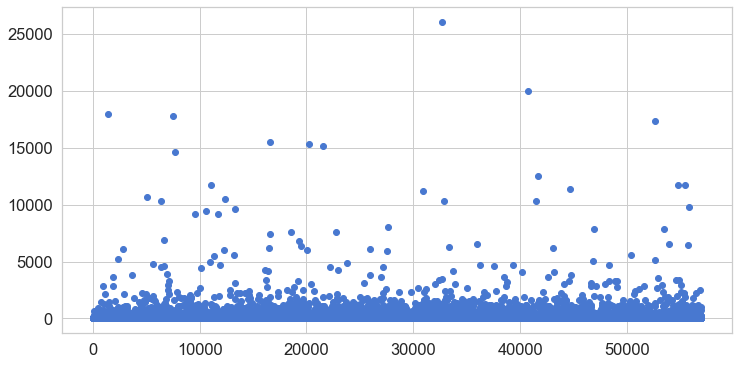

In [130]:
# Tehtävän vastaukset. Käytä visualisaatiota tai osoita numeerisesti, kuinka monta poikkeamaa neuroverkkomalli huomasi.
import matplotlib.pyplot as plt

normal_predictions = autoencoder.predict(X_test_normal)
mse_normal = np.mean((X_test_normal - normal_predictions)**2,axis=1)
modified_predictions = autoencoder.predict(X_test_modified)
mse_modified = np.mean((X_test_modified - modified_predictions)**2,axis=1)
predictions_mse = np.concatenate([mse_normal,mse_modified]) # Yhdistetään ennustukset yhteen taulukkoon kuvaajaa varten
fig, ax = plt.subplots(figsize=(12,6))
ax.scatter(range(len(predictions_mse)),predictions_mse)

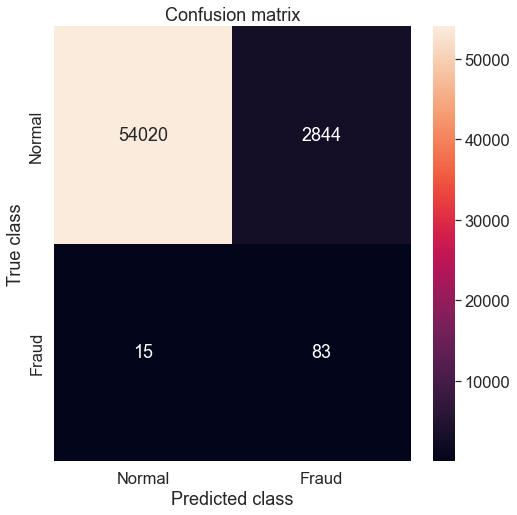

In [162]:
import seaborn as sns 
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc, roc_curve, recall_score, classification_report, 
                             f1_score, precision_recall_fscore_support) 

threshold = 1.5
LABELS = ["Normal", "Fraud"]

y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values] 
conf_matrix = confusion_matrix(error_df.true_class, y_pred) 
plt.figure(figsize=(8, 8)) 
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d"); 
plt.title("Confusion matrix") 
plt.ylabel('True class') 
plt.xlabel('Predicted class') 
plt.show()

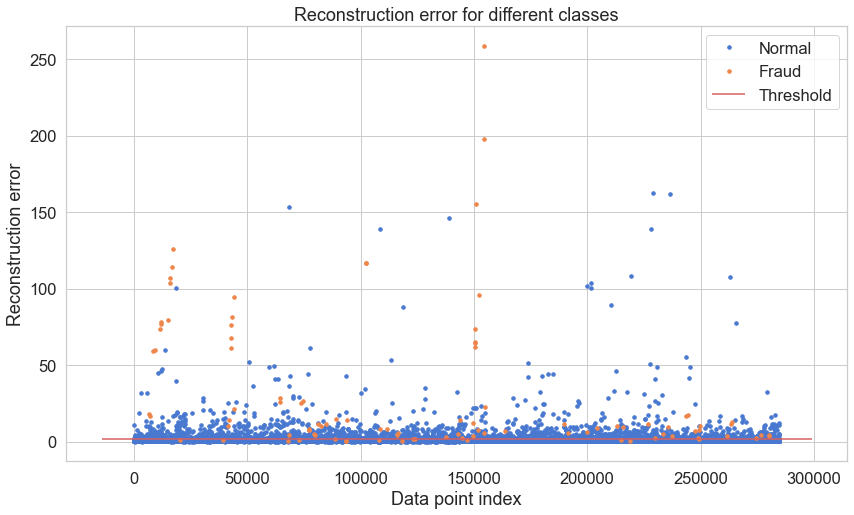

In [163]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

# Tehtävä 4.
### Aihe: Autoenkooderit - Kohinan poisto kuvasta
2,5 pistettä

Alla on luotu MNIST datasetistä "korruptoitunut" versio, jossa kuviin on lisätty kohinaa. Luo autoenkooderi, jolle syötetään suttuinen numero ja joka luo kuvan uudestaan puhtaana numerona.

Todista autoenkooderin toiminta:
1. Piirrä Matplotlibillä testidatasetistä suttuinen kuva (esim. test_X_noisy[10])
2. Syötä suttuinen kuva autoenkooderille.
3. Piirrä autoenkooderin ulostulona antama kuva.
4. Aja "Tehtävän vastaukset" solu

Vinkkejä:
* Mieti, mikä muuttuja menee syötteenä autoenkooderiin ja mikä muuttuja on haluttu lopputulos?
    * Suttuinen kuva -> autoenkooderi -> Selkeä kuva
* Piirrät kuvat käyttäen matplotlib - kirjastoa
    * Autoenkooderi materiaaleissa esimerkki

In [2]:
# Ladataan tarvittavat kirjastot
import tensorflow as tf
import numpy as np

# Puhdas MNIST datasetti, josta otetaan kymmenesosa kuvista datasettiin
(train_X, _), (test_X, _) = tf.keras.datasets.mnist.load_data()
train_X, test_X = train_X[0:len(train_X) // 10], test_X[0:len(test_X) // 10]
train_X, test_X = train_X / 255.0, test_X / 255.0
train_X, test_X = train_X.reshape((train_X.shape[0],28,28,1)), test_X.reshape((test_X.shape[0],28,28,1))

# Luodaan suttuisia kuvia MNIST datasetistä laittamalla kuviin kohinaa
noise = np.random.normal(loc=0.5, scale=0.75, size=train_X.shape)
train_X_noisy = train_X + noise
noise = np.random.normal(loc=0.5, scale=0.75, size=test_X.shape)
test_X_noisy = test_X + noise
train_X_noisy = np.clip(train_X_noisy, 0., 1.) 
test_X_noisy = np.clip(test_X_noisy, 0., 1.)

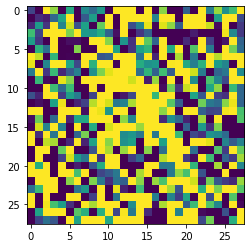

Model: "Encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 4, 4, 64)          36928     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_2 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                6560

In [7]:
# Tehtävän toteutus
import matplotlib.pyplot as plt

# Piirrä Matplotlibillä testidatasetistä suttuinen kuva (esim. test_X_noisy[10])
test_img = test_X_noisy[10]
test_img = test_img.reshape(test_img.shape[0], test_img.shape[1])
plt.imshow(test_img)
plt.show()

# Syötä suttuinen kuva autoenkooderille.
# luodaan ensin enkooderi
enc_input = tf.keras.Input(shape=(28,28,1))
enc_conv1 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2,2), activation='relu', padding='same')(enc_input)
enc_conv2 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2,2), activation='relu', padding='same')(enc_conv1)
enc_conv3 = tf.keras.layers.Conv2D(64, 3, 2, activation='relu', padding='same')(enc_conv2)
enc_conv4 = tf.keras.layers.Conv2D(64, 3, 1, activation='relu', padding='same')(enc_conv3)
enc_flatten = tf.keras.layers.Flatten()(enc_conv4)
enc_out = tf.keras.layers.Dense(64, activation='linear')(enc_flatten) 
encoder = tf.keras.Model(inputs=enc_input, outputs=enc_out, name='Encoder')
encoder.summary()

# sitten luodaan dekooderi
dec_input = tf.keras.Input(shape=(64,))
dec_dense1 = tf.keras.layers.Dense(7*7*64, activation='relu')(dec_input)
dec_reshape = tf.keras.layers.Reshape(target_shape=(7,7,64))(dec_dense1)
dec_convt1 = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=(2,2), padding='same', activation='relu')(dec_reshape)
dec_convt2 = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=(2,2), padding='same', activation='relu')(dec_convt1)
dec_convt3 = tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=(1,1), padding='same', activation='relu')(dec_convt2)
dec_out = tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=(1,1), padding='same', activation='sigmoid')(dec_convt3)
decoder = tf.keras.Model(inputs=dec_input, outputs=dec_out, name='Decoder')
decoder.summary()

# yhdistetään enkooderi ja dekooderi
autoencoder_input = tf.keras.Input(shape=(28,28,1), name='Autoencoder_input')
encoder_out = encoder(autoencoder_input)
decoder_out = decoder(encoder_out)
autoencoder = tf.keras.Model(inputs=autoencoder_input, outputs=decoder_out, name='Autoencoder')
autoencoder.summary()

# koulutetaan autoenkooderi
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001), loss='mean_squared_error')
autoencoder.fit(test_X_noisy, test_X_noisy, epochs=5, batch_size=16)

# luodaan autoenkooderilla kuva uudelleen
test_img = test_img.reshape(1,28,28,1)
prediction = autoencoder.predict(test_img)
cleaned_img = prediction.reshape(prediction.shape[1], prediction.shape[2])

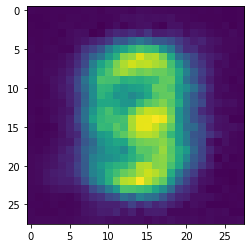

In [4]:
# Tehtävän vastaukset.  Huom! Älä muokkaa tätä solua, vaan aja se, kun olet suorittanut tehtävän. 
# Syötä cleaned_img - muuttujaan autoenkooderin ulostulo. Muista muokata sitä ennen ulostulo takaisin 28x28 matriisiksi, jotta sen voi syöttää plt.imshow() funktiolle.
plt.imshow(cleaned_img)

# Extra Tehtävä
### Aihe: Twiitin klassifiointi - Positiivinen vai negatiivinen?
2,5 pistettä

Tämä on ylimääräinen tehtävä, jonka avulla voit saada muutaman lisäpisteen.

Lataa datasetti osoitteesta https://student.labranet.jamk.fi/~korpjo/files/Sentiment-Analysis-Dataset.zip. Datasetissä on twiittejä, jotka on leimattu positiiviseksi (1) tai negatiiviseksi (0) Sentiment - sarakkeessa.

Twiiteissä on paljon turhaa tavaraa, kuten linkkejä ja viittauksia muihin käyttäjiin @ - merkillä, jotka eivät auta tai haittaavat neuroverkkoja klassifioimaan twiittejä. Muokkaa datasettiä ja luo neuroverkkomalli, joka ennustaa, onko twiitti positiivinen vai negatiivinen. 

Jaa data koulutus- ja testidataan (80% koulutusdataa 20% testidataa jako) ja mittaa kuinka tarkka mallisi on testidatan avulla.

Vinkkejä:
* Tekstin esikäsittelyyn voi käyttää esim. TensorFlowin Tokenizer - luokkaa: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer
* Viittauksia ja linkkejä ei välttämättä tarvitse poistaa, vaan ne voi korvata yleisesti jollakin merkkijonolla. Esim. "http://iltalehti.fi" -> "link_to_website" tai "@elonmusk" -> "reference_to_user"

In [ ]:
# Tehtävän toteutus